# Code example accompanying "A cloud screening algorithm for ground-based aerosol optical depth measurements using all-sky images and deep transfer learning."

In [104]:
import cv2
import glob
import matplotlib.pyplot as plt
import natsort
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model, load_model

Clone the project repository to get access to the raw images.

In [105]:
!git clone https://github.com/eawendt/aodqc.git

fatal: destination path 'aodqc' already exists and is not an empty directory.


## Pre-processing functions

The following functions are used to crop an all-sky image to the . Functions with a leading _ are intermediate function. To pre-process an all-sky image, call the ```crop_image``` function with your image as the argument. Before passing the cropped image into the classifier model, be sure to pass the cropped image into the ```prep_vgg``` function, which will scale the channels to values that vgg expects.



In [106]:
# Data import
def _standardize_image(image, edge_len = 840):
  '''
  Standardizes input images to a default size of 840x840 pixels

    Parameters:
      image: An all-sky image
      edge_len: The desired edge length

    Returns:
      scaled: A scaled image
  '''
  scale = edge_len / image.shape[0]

  scaled_image = cv2.resize(image, None, fx = scale, fy = scale, interpolation = cv2.INTER_AREA)
  
  col1 = int((scaled_image.shape[1] - scaled_image.shape[0]) / 2)
  col2 = int(scaled_image.shape[1] - col1)

  row1 = int(0)
  row2 = int(scaled_image.shape[1])

  scaled = scaled_image[row1:row2, col1:col2]

  return(scaled)

# Processing
def _threshold_image(image):
  '''
  Applies a multistage thresholding procedure to an all-sky image

    Parameters:
      image: An all-sky image
    
    Returns:
      seg: An all-sky image with the sunlit pixels isolated
  '''
  b = image[:, :, 0] # Get only the blue channel
  th, seg_tmp = cv2.threshold(b, 252, 255, cv2.THRESH_BINARY)
  seg_tmp  = cv2.GaussianBlur(src = seg_tmp , ksize = (15, 15), sigmaX = 0)
  seg_tmp  = cv2.bilateralFilter(src = seg_tmp , d = 15, sigmaColor = 25, sigmaSpace = 25)
  th, seg = cv2.threshold(seg_tmp, 50, 255, cv2.THRESH_BINARY)

  return seg

def _calc_sun_contour(seg):
  '''
  Finds the contour most likely to be the solar disk.

    Parameters:
      seg: A previously thresholded all-sky image.

    Returns: The contour of the solar disk.
  '''
  contours, hierarchy = cv2.findContours(image = seg, mode = cv2.RETR_EXTERNAL, method = cv2.CHAIN_APPROX_SIMPLE)

  max_circ = 0
  sun = None

  for cn in contours:
    area = cv2.contourArea(cn)
    if (area > 2750):
      arc_length = cv2.arcLength(cn, True)
      circularity = 4 * np.pi * area / (arc_length * arc_length)
      if circularity > max_circ:
          max_circ = circularity
          sun = cn
  
  return sun

def _calc_sun_center(contour):
  '''
  Finds the center of a contour, in this case, the contour of the solar disk.

    Parameters:
      contour: A contour returned by the _calc_sun_contour() function

    Returns:
      cx: The row of the image containing the center of the solar disk
      cy: The column of the image containing the center of the solar disk
  '''
  M = cv2.moments(contour)
  cx = int(M["m01"] / M["m00"])
  cy = int(M["m10"] / M["m00"])

  return cx, cy

def _crop_to_sun(image, cx, cy, offset = 112):
  '''
  Crops the image around the solar disk. If no solar disk is found, then it
  crops the image in the center of the image. 

    Parameters:
      image: A scaled all-sky image.
      cx: The row of the image containing the center of the solar disk
      cy: The column of the image containing the center of the solar disk
      offset: Desired offset from center of the solar disk. Default 112
      for shape of 224x224.

    Returns:
      cropped: Cropped all-sky image
  '''

  xmax = image.shape[0]
  ymax = image.shape[1]

  # Find how much space there is between sun center and edge of image
  spc_xl = cx
  spc_xu = xmax - cx
  spc_yl = cy
  spc_yu = ymax - cy

  if (cx <= offset):
    xl = cx
  else:
    xl = offset
  
  if ((xmax - cx) <= offset):
    xu = xmax - cx
  else:
    xu = offset

  if (cy <= offset):
    yl = cx
  else:
    yl = offset
  
  if ((ymax - cy) <= offset):
    yu = ymax - cy
  else:
    yu = offset

  cropped = image[(cx - xl):(cx + xu), (cy - yl):(cy + yu)]
  
  return cropped

def crop_image(image, offset = 112):
  '''
  Returns a cropped all-sky image

    Parameters:
      image: An unprocessed all-sky image
      offset: Desired offset from center of the solar disk. Default 112
      for shape of 224x224.

    Returns:
      cropped: A cropped all-sky image
  '''
  scaled = _standardize_image(image = image)
  seg = _threshold_image(image = scaled)
  sun = _calc_sun_contour(seg = seg)
  if sun is not None:
    # If the sun is found, calculate the center of the sun
    cx, cy = _calc_sun_center(contour = sun)
  else:
    # If the sun is not found, set center equal to the center of the scaled image
    cx, cy = int(scaled.shape[0] / 2), int(scaled.shape[1] / 2)

  cropped = _crop_to_sun(image = scaled, cx = cx, cy = cy, offset = offset)
  return cropped

def prep_vgg(image):
  '''
  Returns an image prepared to interface with vgg network

  Parameters:
    images: Cropped all-sky image

  Returns:
    im_vgg: image prepared for input into vgg
  '''
  im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 gives bgr by default while vgg expects rgb
  im_vgg = preprocess_input(im_rgb)
  return im_vgg


### Testing pre-process function on a random image

Function to show the image using matplotlib. Note that opencv using BGR color channels so we need to convert to RGB before displaying with matplotlib.

In [107]:
def show_image(img):
  img_rgb = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2RGB)
  fig = plt.figure(figsize=[6, 6]);
  plt.axis("off");
  plt.imshow(img_rgb);

Get a sorted list of raw image files.

In [108]:
raw_image_files = natsort.natsorted(glob.glob('aodqc/images/*/*/*.jpg'))

In [109]:
rand_ind = random.randint(0, len(raw_image_files))
raw_image = cv2.imread(raw_image_files[rand_ind]) # Change this to look at a specific image

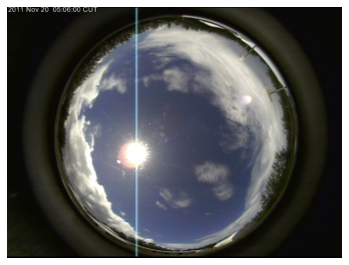

In [110]:
show_image(raw_image)

In [111]:
cropped = crop_image(raw_image)

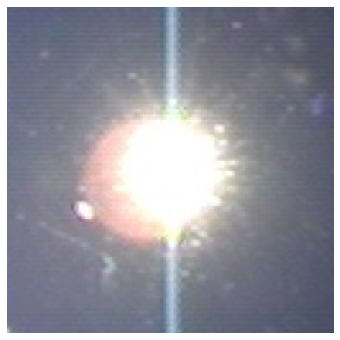

In [112]:
show_image(cropped)

## Run the classifier on the random image

Load in a model using the tensorflow load_model function

In [113]:
model_7 = load_model('/content/aodqc/models/model_7.h5')

Scale the data to be interfaced with VGG

In [114]:
im_vgg = prep_vgg(cropped)

Define class labels: 
* 0 = cirrus
* 1 = clear
* 2 = cloud

In [115]:
classes = ['Cirrus', 'Clear', 'Cloud']

Run the model to predict the output. Note that the tensorflow predict function expects a 4D tensor, which is why we append a fourth axis using ```tf.newaxis```.

In [116]:
pred_index = model_7.predict(im_vgg[tf.newaxis,:,:,:]).argmax()
pred_class = classes[pred_index]

Plot the cropped image along with the class prediction designation.

<Figure size 432x432 with 0 Axes>

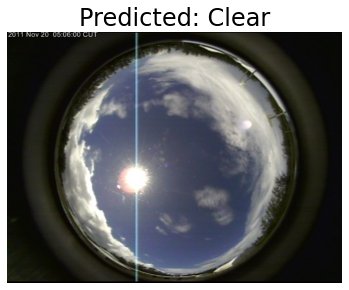

In [117]:
fig = plt.figure(figsize=(6,6));
show_image(raw_image);
plt.title(f'Predicted: {pred_class}', fontsize=24);
plt.axis('off');